# MaDeLaNE: Workshop on effective connectivity

Connectivity can be characterized in two ways, functional connectivity and effective connectivity. While functional connectivity describes statistical dependencies between data, effective connectivity deals with the causal influences between the data. 

<b>Mutual information</b>[1] and <b>directed information</b>[2] are two metrics that can be used to study the connectivity between two neurons. 

<b>Mutual information</b> quantifies the amount of information that one random variable (or neural signal, in our case) contains about another. It is a symmetric measure, and better suited to study the functional connectivity between neural signals. 
    
<b>Directed information</b>, on the other hand, is a causal metric. It measures the amount of information that one time series carries about another when predicting its future values, thus indicating the direction of influence. Directed information provides an estimate of the effective connectivity between the signals. For two random variables, directed information is described as, 
    $$I(X^{n} \rightarrow Y^{n}) = H(Y^{n}) - \displaystyle \sum_{i=1}^{n} \left[H(Y_{i}|Y^{i-1}, X^{i})\right] $$


Lets first import some basic dependencies and simulate single unit activity to understand how DI is estimated. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from random import seed, random
import pandas as pd
from scipy import signal
from scipy.stats import f_oneway

import utils


We will use the <b>Izhikevich neuron model</b> [3] to simulate spiking activity in two neurons that are connected such that neuron 1 causally influences neuron 2. Both of these neurons are provided with input current simulating the presense of a stimulus during the entire trial.

In [2]:
# Initializations
duration = 1 # in seconds
num_trials = 10  
num_units = 2
step_size = 1e-3 # in seconds
Fs = 1/step_size # sampling frequency
T =int(duration / step_size) # duration in samples

# weights - 2D matrix summarizing the strength of connectivity between the units
#         - rows corresponds to effect variables, columns are the causal variables
weights = np.array([[0, 0], [0.7, 0]]) # neuron 1 -> neuron 2, with a strength of 0.7

input_current = [100, 100]

In [3]:
# Simulate spiking

simulated_spikes = utils.simulate(num_units=num_units, num_trials=num_trials,
                                  duration=duration, step_size= step_size, weights = weights, inp_curr=input_current)

simulated_spikes

,spike_times
0,"[[59, 138, 205, 278, 319, 397, 452, 528, 596, ..."
1,"[[48, 80, 151, 216, 283, 300, 354, 415, 470, 5..."


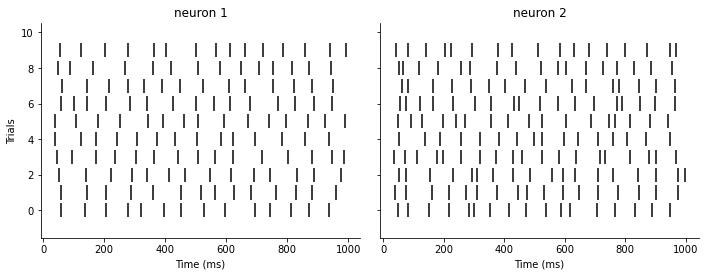

In [4]:
# make the raster plot
fig, ax = plt.subplots(1, num_units, sharey = True, figsize =(10, 4))
spike_times = simulated_spikes.spike_times.values
for unit in range(num_units):
    ax[unit].eventplot(spike_times[unit], linelength = 0.8, color = 'k')
    
    # plot clean up 
    ax[unit].set_title('neuron ' + str(unit+1))
    ax[unit].spines['top'].set_visible(False)
    ax[unit].spines['right'].set_visible(False)
    ax[unit].set_xlabel('Time (ms)')
plt.rcParams.update({'font.size': 12})
ax[0].set_ylabel('Trials')
plt.tight_layout()

In [5]:
# Function to evaluate spike rates
def calculate_rate(T, win, spikes = None, spike_times = None):
    if spikes is None:
        spikes = np.zeros(T)
        spikes[spike_times] = 1
    S = np.zeros(T)
    for t in range(0, T):
        S[t] = np.sum(spikes[t - win:t + 1])
    return S/win

# window for boxcar filter
rate_w = int(0.01*Fs)

# evaluate spike rate for each trial
rates = np.array([[calculate_rate(T, win = rate_w, spike_times = spike_times) 
                   for spike_times in row.spike_times] for _, row in simulated_spikes.iterrows()])

How does the correlation changes if we were to change the strength of connection between these units?

In [6]:
# function to evaluate the avg. cross correlation between rates
def avg_cross_correlation(rates1, rates2, maxlags): 
    num_trials, T = rates1.shape
    cross_correlations = [np.correlate(rates1[i], rates2[i], mode='full') for i in range(num_trials)]
    
    if maxlags is not None:
        lags = np.arange(-T + 1, T)
        trim_idx = (lags >= -maxlags) & (lags <= maxlags)
        cross_correlations = [cross_corr[trim_idx] for cross_corr in cross_correlations]
        lags = lags[trim_idx]
    else:
        lags = np.arange(-T + 1, T)

    return lags, np.mean(cross_correlations, axis=0), np.std(cross_correlations, axis=0)/np.sqrt(num_trials)

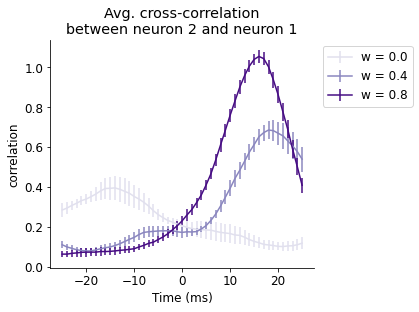

In [7]:
# set maxlag
maxlags = int(0.025*Fs)

fig, ax = plt.subplots(figsize =(6, 4.5))

# colors for plotting 
colors = [cm.Purples(i) for i in np.linspace(0, 1, 25)][5::9]

for n, w in enumerate(np.arange(0, 1.1, 0.4)):
    # adjust the connectivity strength
    weights_n = np.array([[0, 0], [w, 0]])
    
    # simulate the network
    simulation_n = utils.simulate(num_units=num_units, num_trials=num_trials,
                                      duration=duration, step_size= step_size, weights = weights_n, inp_curr=input_current)
    
    
    # calculate spike rates
    rates_n = np.array([[calculate_rate(T, win = rate_w, spike_times = spike_times) for spike_times in row.spike_times] for _, row in simulation_n.iterrows()])
    
    # calculate the trial averaged cross correlation 
    lags_n, mean_corr_n, sem_corr_n = avg_cross_correlation(rates_n[1], rates_n[0], maxlags=maxlags)
    
    # plot it
    ax.errorbar(lags_n, mean_corr_n, yerr = sem_corr_n, linestyle = '-',
                color = colors[n], label = 'w = ' + str(np.round(w, 2)));

# plot clean up  
ax.legend(bbox_to_anchor = (1.01, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Avg. cross-correlation\nbetween neuron 2 and neuron 1')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('correlation')
plt.rcParams.update({'font.size': 12})
plt.tight_layout()

So the simulations are working! 

Important: Cross-correlation serves as an excellent initial step to assess functional connectivity, particularly for capturing linear relationships between neural signals. However, interactions among single neurons in the brain are often non-linear. Consequently, relying solely on cross-correlation analyses might overlook significant interactions in such cases. To capture non-linear interactions between units, <b> directed information </b> serves as a better metric. 

Now, let's see how to calculate directed information between these units.

## Directed Information

To calculate directed information on point process data[4], we need to consider several key components:

1. <b>Rate function</b>:  Determine the intensity function, representing the spike rate. Recommended types of intensity functions: boxcar or Gaussian filter. 
<br> </br>
2. <b>Rate function filter width</b>: The width of the filter used is crucial in determining the temporal resolution at which interactions can be detected. 
<br></br>
3. <b>Memory</b>: Define the length of past history to consider when evaluating directed information. This parameter can be determined based on experimental requirements, the window of interest, or through empirical testing with various values.
<br></br>
4. <b>Kernel width of the Gram matrix</b>: This parameter influences how similar closely related data points are considered when assessing temporal dependencies and interactions within the point process data.
<br></br>
Advanced hyperparameters include: 
1. Kernel to evaluate the Gram matrix
2. Order of alpha entropy 

In [8]:
from calculate_DI import directed_information

Since we modeled our data such that neuron 1 $(n_1)$ causally influences neuron 2 $(n_2)$, we should see that 

$$ DI (n_1 \rightarrow n_2) > DI (n_2 \rightarrow n_1)$$   

In [9]:
%%time
# Initialize
di = {(n1, n2): np.zeros(num_trials) + np.nan for n1 in range(num_units) for n2 in range(num_units) if n1 != n2}
memory = 15

# Evaluate DI for each trial and in both directions
for trial in range(num_trials):
    for n1 in range(num_units):
        for n2 in range(num_units):
            if n1 != n2:
                model = directed_information(memory=memory)
                di[(n1, n2)][trial] = model.DI(rates[n1, trial], rates[n2, trial])

Wall time: 4min 51s


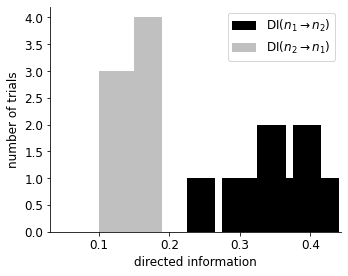

In [10]:
# plot the histogram of DI in either directions for comparison 
fig,ax = plt.subplots(figsize = (5, 4))
lim = np.max(np.concatenate((di[(0, 1)], di[(1, 0)])))
ax.hist(di[(0, 1)], color = 'k', bins = np.arange(0.05, lim, 0.025), label = r"DI($n_1\rightarrow n_2$)", width = 0.04)
ax.hist(di[(1, 0)], color = 'silver', bins = np.arange(0.05, lim, 0.025), label = r"DI($n_2\rightarrow n_1$)", width = 0.04)

# plot clean up
ax.set_xlabel('directed information')
ax.set_ylabel('number of trials')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams.update({'font.size': 12})
ax.legend()
plt.tight_layout()


### Hyperparameter tuning

How do memory and Kernel width of the Gram matrix influence the calculation of directed information?

#### Memory size 

In [11]:
%%time
trial = 8 # picking a random trial
memory_range = [2] + list(np.arange(5, 30, 5)) # memory range to sweep over

# Initialize
di_memory = {(n1, n2): np.zeros(len(memory_range)) + np.nan for n1 in range(num_units) for n2 in range(num_units) if n1 != n2}

# loop through the memory values
for n, memory in enumerate(memory_range):
    for n1 in range(num_units):
        for n2 in range(num_units):
            if n1 != n2:
                model = directed_information(memory=memory) 
                di_memory[(n1, n2)][n] = model.DI(rates[n1, trial], rates[n2, trial])

Wall time: 2min 31s


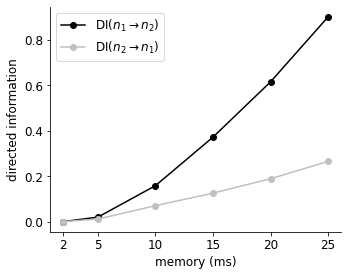

In [12]:
# plot the DI values for the memory range
fig, ax = plt.subplots(figsize = (5, 4))
ax.plot(memory_range, di_memory[(0, 1)], color = 'k', marker = 'o', label = r"DI($n_1\rightarrow n_2$)")
ax.plot(memory_range, di_memory[(1, 0)], color = 'silver', marker = 'o', label = r"DI($n_2\rightarrow n_1$)")
 
# plot clean up 
ax.set_xlabel('memory (ms)')
ax.set_ylabel('directed information')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(memory_range)
plt.rcParams.update({'font.size': 12})
ax.legend()
plt.tight_layout()

As we increase the memory size, the directed information also grows. It's essential to choose an appropriate memory size to effectively capture the interactions within spiking data. For instance, at a memory size of 2 ms, we observe no discernible difference between the causal and non-causal directions. This observation aligns with our simulation, where we modeled a time delay of ~10 ms for the affected neuron to receive the input. 

#### Kernel width of the Gram matrix

Next, lets look at the effect of the kernel width of the Gram matrix on DI. The Gram matrix captures the variance in the data and is an important component for entropy estimation. 


For a variable $X = \{\textbf{x}_i\}_{i = 1}^{N} $, the Gram matrix, $K$, is an $N \times N$ matrix whose entries are given by $\kappa(\textbf{x}_i\ ,  \textbf{x}_j), i, j = 1, ..., N$, where $\kappa$ is a kernel function. This function dictates the extent of similarity between various realizations of $X$. 

For our puposes, we use a Gaussian kernel to evaluate the Gram matrix of each of the input variables and its kernel width dictates the extent of similarity between data points. 

In [13]:
%%time
trial = 8 # picking a random trial
kernel_widths = [1e-1, 2, 5, 10, 20, 30] # range of widths to sweep over
memory = 15

# Initialize
di_kw = {(n1, n2): np.zeros(len(kernel_widths )) + np.nan for n1 in range(num_units) for n2 in range(num_units) if n1 != n2}

# Evaluate DI for different memory values
for n, width in enumerate(kernel_widths):
    for n1 in range(num_units):
        for n2 in range(num_units):
            if n1 != n2:
                model = directed_information(memory = memory, multiplier_X = width, multiplier_Y = width)
                di_kw[(n1, n2)][n] = model.DI(rates[n1, trial], rates[n2, trial])

Wall time: 2min 51s


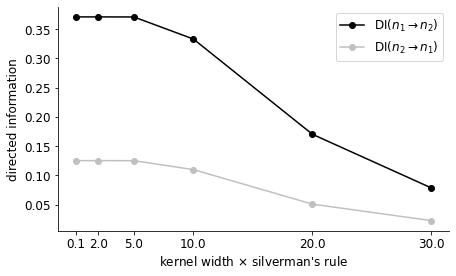

In [27]:
# plot the DI values for different kernel widths
fig, ax = plt.subplots(figsize = (6.5, 4))
ax.plot(kernel_widths, di_kw[(0, 1)], color = 'k', marker = 'o', label = r"DI($n_1\rightarrow n_2$)")
ax.plot(kernel_widths, di_kw[(1, 0)], color = 'silver', marker = 'o', label = r"DI($n_2\rightarrow n_1$)")
  
# plot clean up 
ax.set_xlabel(r"kernel width $\times$ silverman's rule")
ax.set_ylabel('directed information')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(kernel_widths)
plt.rcParams.update({'font.size': 12})
ax.legend()
plt.tight_layout()

Very high values would group almost all points as being similar, meaning that no additional information is needed to explain the variance in the effect variable since all information can be obtained from its own values. No knowledge from the past values of the causal variable is needed and we see a drop in directed information. 

Very low values, on the other hand, would group all points as being dissimilar, and so we see an increase in directed information. In real scenarios, in the absence of ground truth, this could lead to falsely detected causal influences. 

#### Questions: 
Directed information is unbounded. So, in the absence of ground, what are some ways by which you can find a significant causal effect between units? 

How about filtering out indirect causal effects like $n_1 \rightarrow n_2$ and $n_2 \rightarrow n_3$ gives $n_1 \rightarrow n_3$?   

### References 

[1] Cover, Thomas M. Elements of information theory. John Wiley & Sons, 1999.

[2] Massey, James. "Causality, feedback and directed information." Proc. Int. Symp. Inf. Theory Applic.(ISITA-90). Vol. 2. 1990.

[3] Izhikevich, Eugene M. Dynamical systems in neuroscience. MIT press, 2007.

[4] Akella, Shailaja, et al. "Measurable fields-to-spike causality and its dependence on cortical layer and area." bioRxiv (2023).